In [1]:
!nvidia-smi

Mon Apr  7 09:57:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P3             13W /   55W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[0]	Test-auc:0.74272
[1]	Test-auc:0.75517
[2]	Test-auc:0.76377
[3]	Test-auc:0.77029
[4]	Test-auc:0.77460
[5]	Test-auc:0.77962
[6]	Test-auc:0.78396
[7]	Test-auc:0.78710
[8]	Test-auc:0.79017
[9]	Test-auc:0.79227
[10]	Test-auc:0.79394
[11]	Test-auc:0.79534
[12]	Test-auc:0.79660
[13]	Test-auc:0.79805
[14]	Test-auc:0.79904
[15]	Test-auc:0.79988
[16]	Test-auc:0.80066
[17]	Test-auc:0.80143
[18]	Test-auc:0.80245
[19]	Test-auc:0.80290
[20]	Test-auc:0.80345
[21]	Test-auc:0.80422
[22]	Test-auc:0.80565
[23]	Test-auc:0.80616
[24]	Test-auc:0.80674
[25]	Test-auc:0.80731
[26]	Test-auc:0.80792
[27]	Test-auc:0.80864
[28]	Test-auc:0.80904
[29]	Test-auc:0.80936
[30]	Test-auc:0.80961
[31]	Test-auc:0.80996
[32]	Test-auc:0.81054
[33]	Test-auc:0.81083
[34]	Test-auc:0.81109
[35]	Test-auc:0.81146
[36]	Test-auc:0.81207
[37]	Test-auc:0.81231
[38]	Test-auc:0.81252
[39]	Test-auc:0.81282
[40]	Test-auc:0.81306
[41]	Test-auc:0.81324
[42]	Test-auc:0.81356
[43]	Test-auc:0.81391
[44]	Test-auc:0.81399
[45]	Test-auc:0.8141

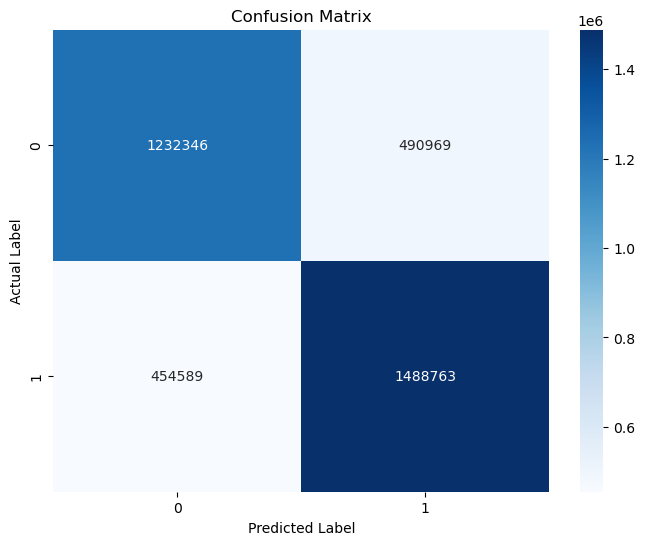

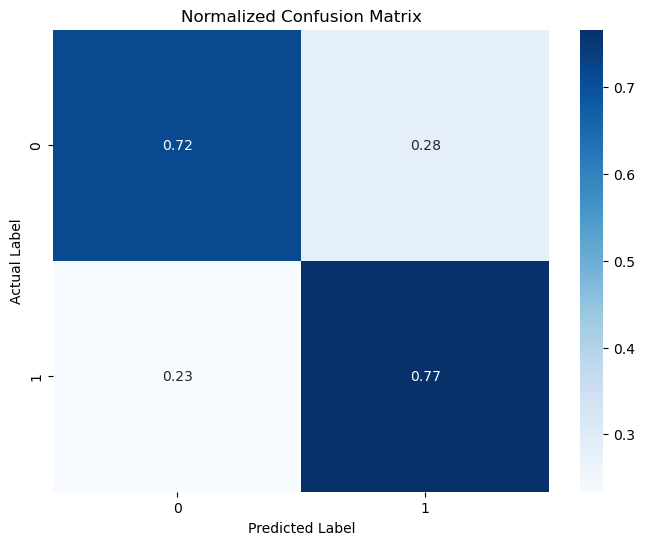

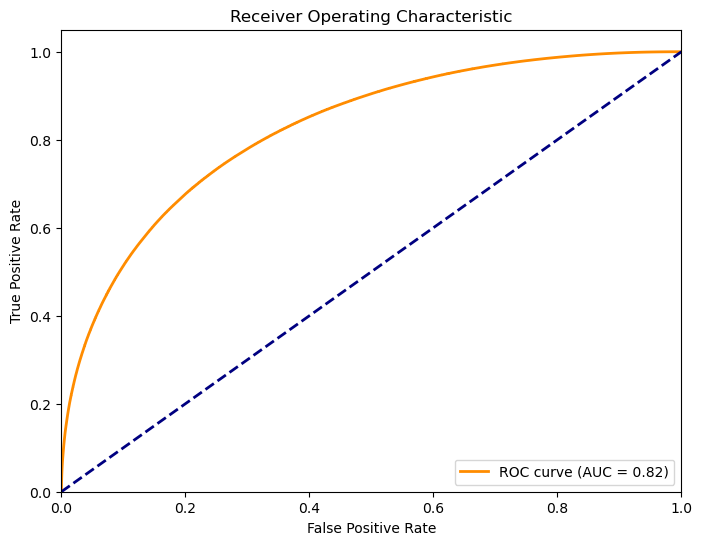

In [1]:
import cudf
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# -----------------------------
# Data Loading and Preparation
# -----------------------------
# Load pre-split datasets using cudf
higgs_train = cudf.read_csv("higgs_train.csv")
higgs_test = cudf.read_csv("higgs_test.csv")

# Separate features and labels
X_train = higgs_train.drop('class_label', axis=1)
y_train = higgs_train['class_label']
X_test = higgs_test.drop('class_label', axis=1)
y_test = higgs_test['class_label']

# -----------------------------
# XGBoost Model Training
# -----------------------------
# Updated parameters for GPU training on your system
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',     # Use histogram method with GPU acceleration via device
    'device': 'cuda',          # Use CUDA for GPU training
    'eval_metric': 'auc'
}

# Create DMatrices from cudf DataFrames
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model (adjust num_boost_round as needed)
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'Test')])

# -----------------------------
# Predictions and Conversion
# -----------------------------
# Get predicted probabilities from the model
y_pred_prob = bst.predict(dtest)

# Convert cudf Series or numpy array to pandas Series for compatibility with sklearn metrics and plotting
y_test_pd = y_test.to_pandas() if hasattr(y_test, "to_pandas") else pd.Series(y_test)
y_pred_pd = pd.Series((y_pred_prob > 0.5).astype(int))

# -----------------------------
# Test Accuracy
# -----------------------------
test_accuracy = accuracy_score(y_test_pd, y_pred_pd)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# -----------------------------
# Classification Report
# -----------------------------
print("Classification Report:")
print(classification_report(y_test_pd, y_pred_pd))

# -----------------------------
# Confusion Matrix (Raw)
# -----------------------------
cm = confusion_matrix(y_test_pd, y_pred_pd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# -----------------------------
# Normalized Confusion Matrix
# -----------------------------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# -----------------------------
# ROC-AUC Curve
# -----------------------------
# If y_pred_prob is a cudf Series, convert to pandas
y_pred_prob_pd = y_pred_prob.to_pandas() if hasattr(y_pred_prob, "to_pandas") else pd.Series(y_pred_prob)

# Compute ROC curve and AUC using probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test_pd, y_pred_prob_pd)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


[0]	Test-auc:0.74272
[1]	Test-auc:0.75517
[2]	Test-auc:0.76377
[3]	Test-auc:0.77029
[4]	Test-auc:0.77460
[5]	Test-auc:0.77962
[6]	Test-auc:0.78396
[7]	Test-auc:0.78710
[8]	Test-auc:0.79017
[9]	Test-auc:0.79227
[10]	Test-auc:0.79394
[11]	Test-auc:0.79534
[12]	Test-auc:0.79660
[13]	Test-auc:0.79805
[14]	Test-auc:0.79904
[15]	Test-auc:0.79988
[16]	Test-auc:0.80066
[17]	Test-auc:0.80143
[18]	Test-auc:0.80245
[19]	Test-auc:0.80290
[20]	Test-auc:0.80345
[21]	Test-auc:0.80422
[22]	Test-auc:0.80565
[23]	Test-auc:0.80616
[24]	Test-auc:0.80674
[25]	Test-auc:0.80731
[26]	Test-auc:0.80792
[27]	Test-auc:0.80864
[28]	Test-auc:0.80904
[29]	Test-auc:0.80936
[30]	Test-auc:0.80961
[31]	Test-auc:0.80996
[32]	Test-auc:0.81054
[33]	Test-auc:0.81083
[34]	Test-auc:0.81109
[35]	Test-auc:0.81146
[36]	Test-auc:0.81207
[37]	Test-auc:0.81231
[38]	Test-auc:0.81252
[39]	Test-auc:0.81282
[40]	Test-auc:0.81306
[41]	Test-auc:0.81324
[42]	Test-auc:0.81356
[43]	Test-auc:0.81391
[44]	Test-auc:0.81399
[45]	Test-auc:0.8141

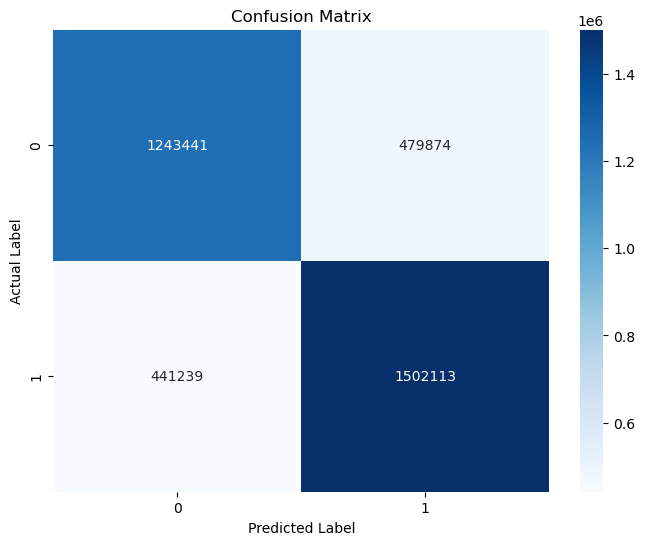

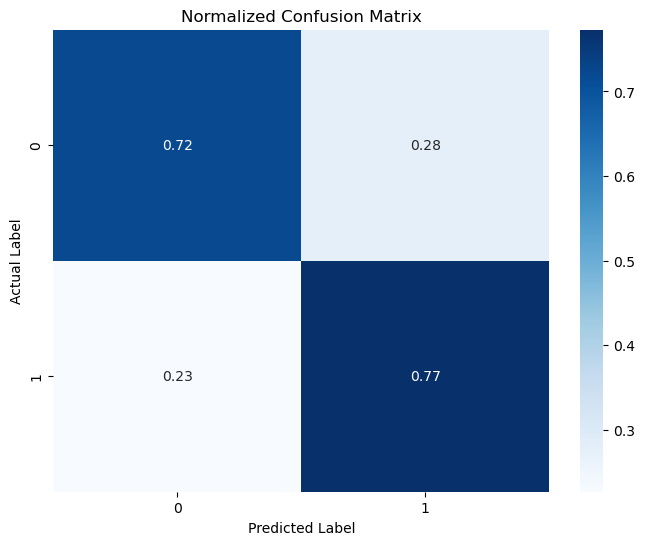

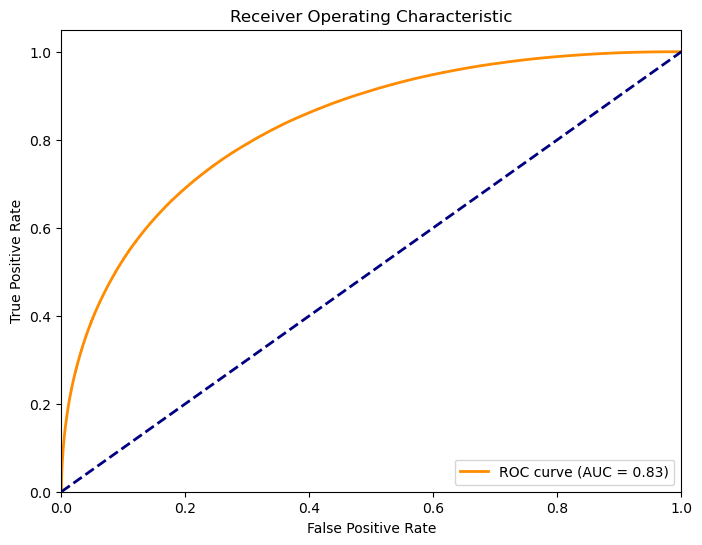

In [1]:
import cudf
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# -----------------------------
# Data Loading and Preparation
# -----------------------------
# Load pre-split datasets using cudf
higgs_train = cudf.read_csv("higgs_train.csv")
higgs_test = cudf.read_csv("higgs_test.csv")

# Separate features and labels
X_train = higgs_train.drop('class_label', axis=1)
y_train = higgs_train['class_label']
X_test = higgs_test.drop('class_label', axis=1)
y_test = higgs_test['class_label']

# -----------------------------
# XGBoost Model Training
# -----------------------------
# Updated parameters for GPU training on your system
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',     # Use histogram method with GPU acceleration via device
    'device': 'cuda',          # Use CUDA for GPU training
    'eval_metric': 'auc'
}

# Create DMatrices from cudf DataFrames
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model (adjust num_boost_round as needed)
bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtest, 'Test')])

# -----------------------------
# Predictions and Conversion
# -----------------------------
# Get predicted probabilities from the model
y_pred_prob = bst.predict(dtest)

# Convert cudf Series or numpy array to pandas Series for compatibility with sklearn metrics and plotting
y_test_pd = y_test.to_pandas() if hasattr(y_test, "to_pandas") else pd.Series(y_test)
y_pred_pd = pd.Series((y_pred_prob > 0.5).astype(int))

# -----------------------------
# Test Accuracy
# -----------------------------
test_accuracy = accuracy_score(y_test_pd, y_pred_pd)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# -----------------------------
# Classification Report
# -----------------------------
print("Classification Report:")
print(classification_report(y_test_pd, y_pred_pd))

# -----------------------------
# Confusion Matrix (Raw)
# -----------------------------
cm = confusion_matrix(y_test_pd, y_pred_pd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# -----------------------------
# Normalized Confusion Matrix
# -----------------------------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# -----------------------------
# ROC-AUC Curve
# -----------------------------
# If y_pred_prob is a cudf Series, convert to pandas
y_pred_prob_pd = y_pred_prob.to_pandas() if hasattr(y_pred_prob, "to_pandas") else pd.Series(y_pred_prob)

# Compute ROC curve and AUC using probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test_pd, y_pred_prob_pd)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


[0]	Test-auc:0.74272
[1]	Test-auc:0.75517
[2]	Test-auc:0.76377
[3]	Test-auc:0.77029
[4]	Test-auc:0.77460
[5]	Test-auc:0.77962
[6]	Test-auc:0.78396
[7]	Test-auc:0.78710
[8]	Test-auc:0.79017
[9]	Test-auc:0.79227
[10]	Test-auc:0.79394
[11]	Test-auc:0.79534
[12]	Test-auc:0.79660
[13]	Test-auc:0.79805
[14]	Test-auc:0.79904
[15]	Test-auc:0.79988
[16]	Test-auc:0.80066
[17]	Test-auc:0.80143
[18]	Test-auc:0.80245
[19]	Test-auc:0.80290
[20]	Test-auc:0.80345
[21]	Test-auc:0.80422
[22]	Test-auc:0.80565
[23]	Test-auc:0.80616
[24]	Test-auc:0.80674
[25]	Test-auc:0.80731
[26]	Test-auc:0.80792
[27]	Test-auc:0.80864
[28]	Test-auc:0.80904
[29]	Test-auc:0.80936
[30]	Test-auc:0.80961
[31]	Test-auc:0.80996
[32]	Test-auc:0.81054
[33]	Test-auc:0.81083
[34]	Test-auc:0.81109
[35]	Test-auc:0.81146
[36]	Test-auc:0.81207
[37]	Test-auc:0.81231
[38]	Test-auc:0.81252
[39]	Test-auc:0.81282
[40]	Test-auc:0.81306
[41]	Test-auc:0.81324
[42]	Test-auc:0.81356
[43]	Test-auc:0.81391
[44]	Test-auc:0.81399
[45]	Test-auc:0.8141

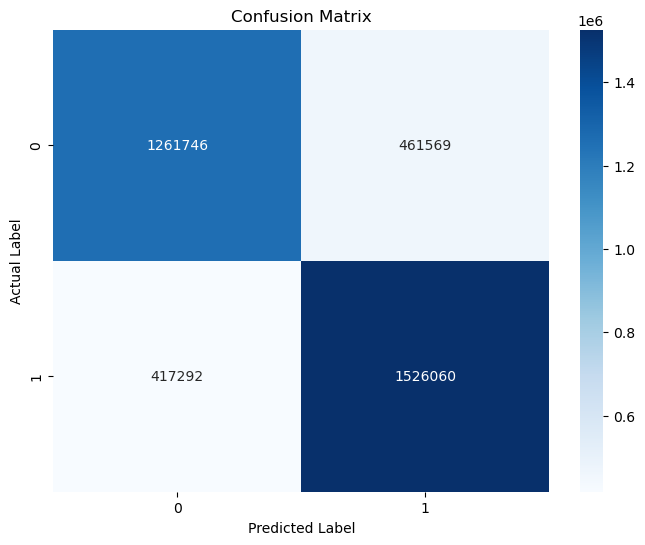

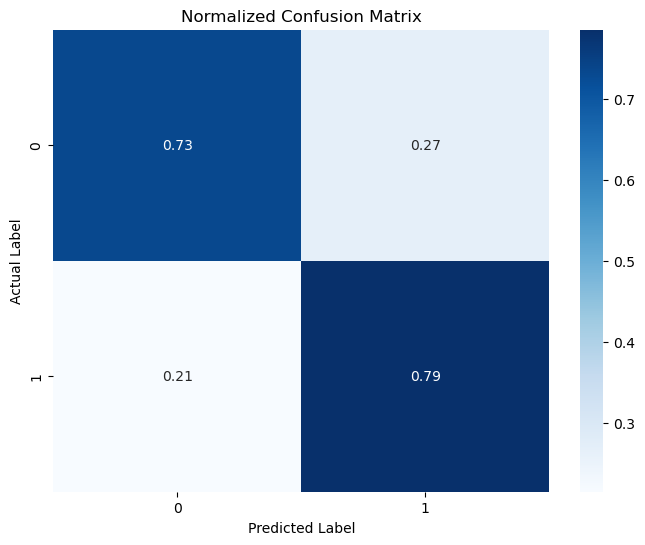

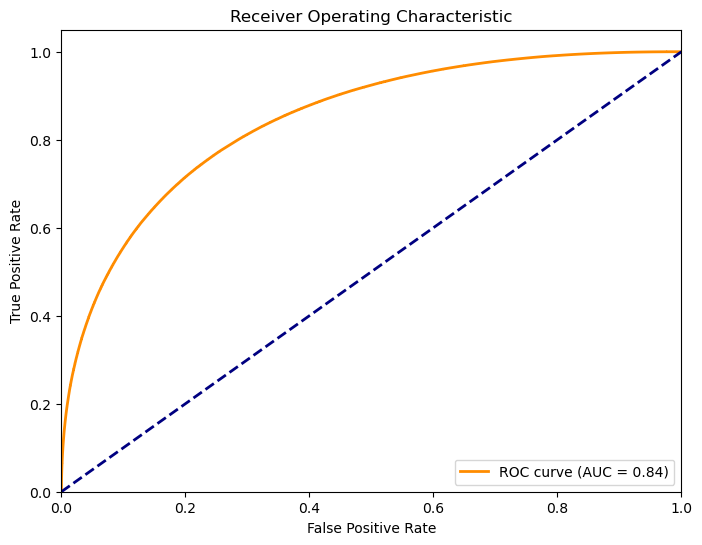

In [1]:
%%time
import cudf
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# -----------------------------
# Data Loading and Preparation
# -----------------------------
# Load pre-split datasets using cudf
higgs_train = cudf.read_csv("higgs_train.csv")
higgs_test = cudf.read_csv("higgs_test.csv")

# Separate features and labels
X_train = higgs_train.drop('class_label', axis=1)
y_train = higgs_train['class_label']
X_test = higgs_test.drop('class_label', axis=1)
y_test = higgs_test['class_label']

# -----------------------------
# XGBoost Model Training
# -----------------------------
# Updated parameters for GPU training on your system
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',     # Use histogram method with GPU acceleration via device
    'device': 'cuda',          # Use CUDA for GPU training
    'eval_metric': 'auc'
}

# Create DMatrices from cudf DataFrames
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model (adjust num_boost_round as needed)
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'Test')], early_stopping_rounds=10, verbose_eval=True)

# -----------------------------
# Predictions and Conversion
# -----------------------------
# Get predicted probabilities from the model
y_pred_prob = bst.predict(dtest)

# Convert cudf Series or numpy array to pandas Series for compatibility with sklearn metrics and plotting
y_test_pd = y_test.to_pandas() if hasattr(y_test, "to_pandas") else pd.Series(y_test)
y_pred_pd = pd.Series((y_pred_prob > 0.5).astype(int))

# -----------------------------
# Test Accuracy
# -----------------------------
test_accuracy = accuracy_score(y_test_pd, y_pred_pd)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# -----------------------------
# Classification Report
# -----------------------------
print("Classification Report:")
print(classification_report(y_test_pd, y_pred_pd))

# -----------------------------
# Confusion Matrix (Raw)
# -----------------------------
cm = confusion_matrix(y_test_pd, y_pred_pd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# -----------------------------
# Normalized Confusion Matrix
# -----------------------------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# -----------------------------
# ROC-AUC Curve
# -----------------------------
# If y_pred_prob is a cudf Series, convert to pandas
y_pred_prob_pd = y_pred_prob.to_pandas() if hasattr(y_pred_prob, "to_pandas") else pd.Series(y_pred_prob)

# Compute ROC curve and AUC using probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test_pd, y_pred_prob_pd)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


[Round 50] AUC: 0.81506 | Current LR: 0.30000
[Round 100] AUC: 0.82385 | Current LR: 0.30000
[Round 150] AUC: 0.82823 | Current LR: 0.30000
[Round 200] AUC: 0.83118 | Current LR: 0.30000
[Round 250] AUC: 0.83343 | Current LR: 0.30000
[Round 300] AUC: 0.83524 | Current LR: 0.30000
[Round 350] AUC: 0.83677 | Current LR: 0.30000
[Round 400] AUC: 0.83793 | Current LR: 0.30000
[Round 450] AUC: 0.83894 | Current LR: 0.30000
[Round 500] AUC: 0.83977 | Current LR: 0.30000
[Round 550] AUC: 0.84058 | Current LR: 0.30000
[Round 600] AUC: 0.84105 | Current LR: 0.30000
[Round 650] AUC: 0.84168 | Current LR: 0.30000
[Round 700] AUC: 0.84217 | Current LR: 0.30000
[Round 750] AUC: 0.84251 | Current LR: 0.30000
[Round 800] AUC: 0.84286 | Current LR: 0.30000
[Round 850] AUC: 0.84320 | Current LR: 0.30000
[Round 900] AUC: 0.84349 | Current LR: 0.30000
[Round 950] AUC: 0.84376 | Current LR: 0.30000

[Round 993] Reducing learning rate to 0.15000
[Round 1000] AUC: 0.84399 | Current LR: 0.15000
[Round 1050] 

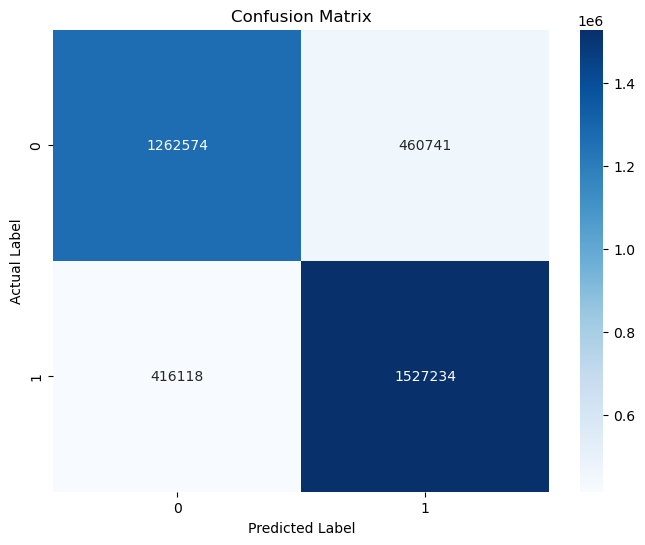

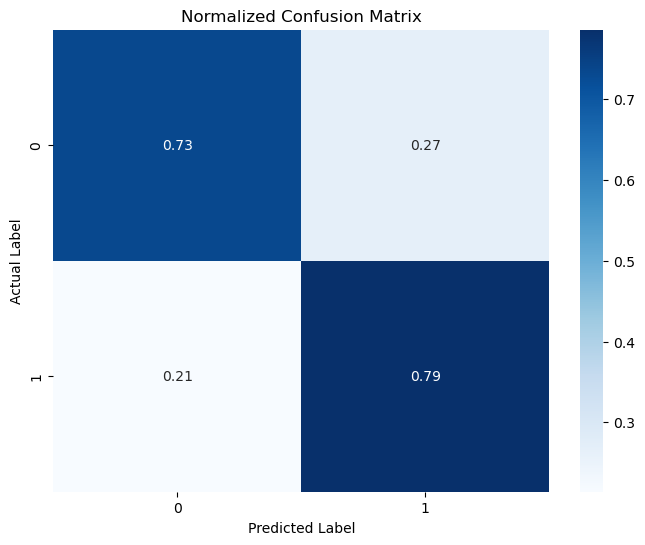

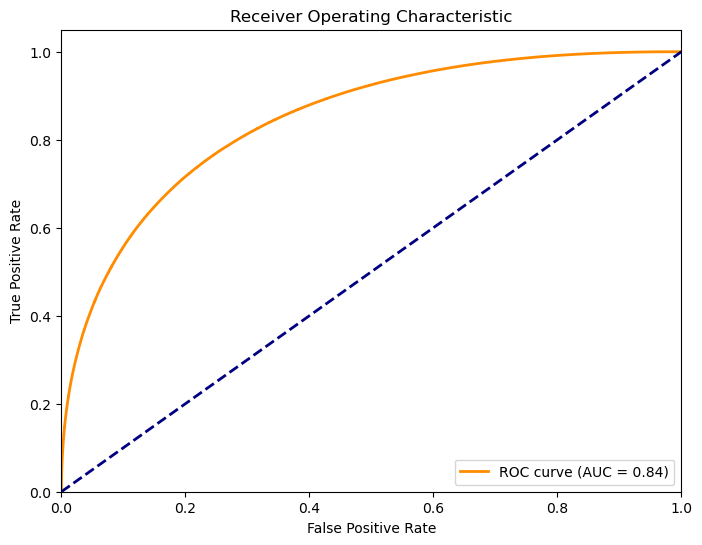

CPU times: user 40min 6s, sys: 5.67 s, total: 40min 12s
Wall time: 40min 24s


In [1]:
%%time
import cudf
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# -----------------------------
# Data Loading and Preparation
# -----------------------------
higgs_train = cudf.read_csv("higgs_train.csv")
higgs_test = cudf.read_csv("higgs_test.csv")

X_train = higgs_train.drop('class_label', axis=1)
y_train = higgs_train['class_label']
X_test = higgs_test.drop('class_label', axis=1)
y_test = higgs_test['class_label']

# -----------------------------
# Parameters
# -----------------------------
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'auc',
    'learning_rate': 0.3
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# -----------------------------
# Custom Callback: Reduce LR on Plateau + Early Stop + Verbose every 50 rounds
# -----------------------------
class ReduceLROnPlateauWithEarlyStop(xgb.callback.TrainingCallback):
    def __init__(self, reduce_patience=3, stop_patience=5, reduce_factor=0.5, verbose_every=50):
        self.best_score = -np.inf
        self.best_iter = 0
        self.wait = 0
        self.lr = params['learning_rate']
        self.reduce_patience = reduce_patience
        self.stop_patience = stop_patience
        self.reduce_factor = reduce_factor
        self.verbose_every = verbose_every

    def after_iteration(self, model, epoch, evals_log):
        current_score = evals_log['Test']['auc'][-1]

        # Print every `verbose_every` rounds
        if (epoch + 1) % self.verbose_every == 0:
            print(f"[Round {epoch+1}] AUC: {current_score:.5f} | Current LR: {self.lr:.5f}")

        if current_score > self.best_score:
            self.best_score = current_score
            self.best_iter = epoch
            self.wait = 0
        else:
            self.wait += 1

            if self.wait == self.reduce_patience:
                self.lr *= self.reduce_factor
                model.set_param('learning_rate', self.lr)
                print(f"\n[Round {epoch+1}] Reducing learning rate to {self.lr:.5f}")

            if self.wait >= self.stop_patience:
                print(f"\n[Round {epoch+1}] Early stopping. Best AUC was {self.best_score:.5f} at round {self.best_iter+1}")
                return True  # Stop training

        return False  # Continue training

# -----------------------------
# Train Model
# -----------------------------
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtest, 'Test')],
    callbacks=[
        ReduceLROnPlateauWithEarlyStop(reduce_patience=3, stop_patience=5, verbose_every=50)
    ],
    verbose_eval=False  # Suppress default logging
)

# -----------------------------
# Predictions & Evaluation
# -----------------------------
y_pred_prob = bst.predict(dtest)
y_test_pd = y_test.to_pandas()
y_pred_pd = pd.Series((y_pred_prob > 0.5).astype(int))

print("\nTest Accuracy: {:.2f}%".format(accuracy_score(y_test_pd, y_pred_pd) * 100))
print("\nClassification Report:")
print(classification_report(y_test_pd, y_pred_pd))

# Confusion Matrix
cm = confusion_matrix(y_test_pd, y_pred_pd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Normalized Confusion Matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC Curve
y_pred_prob_pd = y_pred_prob
fpr, tpr, thresholds = roc_curve(y_test_pd, y_pred_prob_pd)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

